## Simple Titanic Survival Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2021)

## 1. Data

In [2]:
titanic = pd.read_csv('simple_titanic.csv')

- Survived: 생존 유무
- Pclass: 탑승한 여객 클래스
- Sex: 성별
- Age: 나이
- Fare: 운임료
- Embarked: 승선항구 위치
    - C: Cherbourg; Q: Queenstown; S: Southampton

In [3]:
titanic.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked'], dtype='object')

In [5]:
label = titanic['Survived']
data = titanic.drop(['Survived'], axis=1)

### 1.1 EDA

In [6]:
data.describe()

,Pclass,Age,Fare
count,1306.000000,1043.000000,1306.000000
mean,2.296325,29.813202,33.223956
std,0.837037,14.366254,51.765986
min,1.000000,0.170000,0.000000
25%,2.000000,21.000000,7.895800
50%,3.000000,28.000000,14.454200
75%,3.000000,39.000000,31.275000
max,3.000000,80.000000,512.329200


In [10]:
data['Sex'].value_counts()

male      842
female    464
Name: Sex, dtype: int64

In [8]:
data['Embarked'].value_counts()

S    913
C    270
Q    123
Name: Embarked, dtype: int64

Age 변수에 결측치가 존재.

In [11]:
data.isna().sum()

Pclass        0
Sex           0
Age         263
Fare          0
Embarked      0
dtype: int64

정답의 비율을 확인.

In [12]:
label.value_counts()

0    814
1    492
Name: Survived, dtype: int64

### 1.2 Data Preprocess

In [13]:
data.loc[:, 'Sex'] = data['Sex'].map({'male':0, 'female':1})
data.loc[:, 'Embarked'] = data['Embarked'].map({'S':0, 'C':1, 'Q':2})

### 1.3 Data Split

In [14]:
from sklearn.model_selection import train_test_split

train_data, validation_data, train_label, validation_label = train_test_split(data, label, train_size=0.6, random_state=2021)

In [15]:
valid_data, test_data, valid_label, test_label = train_test_split(validation_data, validation_label, train_size=0.5, random_state=2021)

In [16]:
print(f"Train_data size: {len(train_label)}, {len(train_label)/len(data):.2f}")
print(f"Valid_data size: {len(valid_label)}, {len(valid_label)/len(data):.2f}")
print(f"Test_data size: {len(test_label)}, {len(test_label)/len(data):.2f}")

Train_data size: 783, 0.60
Valid_data size: 261, 0.20
Test_data size: 262, 0.20


Index를 초기화.

In [17]:
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

train_label = train_label.reset_index(drop=True)
valid_label = valid_label.reset_index(drop=True)
test_label = test_label.reset_index(drop=True)

## 2. 빈 데이터를 채우는 방법

빈 값이 있는 데이터들.

In [18]:
na_cnt = data.isna().sum()
na_cnt.loc[na_cnt > 0].index

Index(['Age'], dtype='object')

### 2.1 사용하지 않는 방법

- 결측치가 포함된 row를 버리기. dropna함수.
- 이 방법을 Test 데이터에 대해 수행할 경우 비어있는 데이터를 처리할 수 있는 방법이 없어짐.

In [19]:
drop_data = data.dropna()

In [20]:
print(f"전체 데이터 개수: {len(data)}")
print(f"값이 비어있는 데이터를 버린 후 데이터 개수: {len(drop_data)}")
print(f"버려진 데이터 개수: {len(data) - len(drop_data)}")

전체 데이터 개수: 1306
값이 비어있는 데이터를 버린 후 데이터 개수: 1043
버려진 데이터 개수: 263


### 2.2 전체 데이터의 평균으로 채우는 방법

In [23]:
mean_train_data = train_data.copy()
mean_valid_data = valid_data.copy()
mean_test_data = test_data.copy()

학습 데이터의 Age의 평균.

In [24]:
age_mean = mean_train_data['Age'].mean()
age_mean

30.13604100946372

비어있는 데이터들에 대해 값을 채우기.

In [25]:
mean_train_data.loc[:, 'Age'] = mean_train_data['Age'].fillna(age_mean)
mean_valid_data.loc[:, 'Age'] = mean_valid_data['Age'].fillna(age_mean)
mean_test_data.loc[:, 'Age'] = mean_test_data['Age'].fillna(age_mean)

In [26]:
mean_train_data.isna().sum()

Pclass      0
Sex         0
Age         0
Fare        0
Embarked    0
dtype: int64

### 2.3 비슷한 데이터들의 평균으로 채우는 방법

- 전체 데이터들의 평균을 반영하면, 데이터의 특성이 반영되지 않을 수도 있음.

- 빈 값이 있는 변수를 제거.
- 나머지 변수들을 군집화 한 후 군집의 평균으로 빈 값을 채우기.
- 비슷한 데이터들은 변수 몇 개를 제거해도 같이 묶일 것이다.

In [28]:
cluster_train_data = train_data.copy()
cluster_valid_data = valid_data.copy()
cluster_test_data = test_data.copy()

Clustering 이전에 데이터를 정규화.

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(cluster_train_data.drop(['Age'], axis=1))

StandardScaler()

In [30]:
# Age를 제외하고 Clustering 진행.
# 빈 값을 포함하면 값을 찾을 수 없음.
train_fill_data = scaler.transform(cluster_train_data.drop(['Age'], axis=1))
valid_fill_data = scaler.transform(cluster_valid_data.drop(['Age'], axis=1))
test_fill_data = scaler.transform(cluster_test_data.drop(['Age'], axis=1))

- 최적의 K를 찾기 위해 K값에 따른 SSE를 계산.

In [32]:
from sklearn.cluster import KMeans

n_cluster = []
sse = []
for n in range(3, 15, 2):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(train_fill_data)
    n_cluster += [n]
    sse += [kmeans.inertia_]

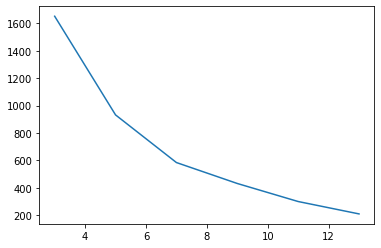

In [33]:
plt.plot(n_cluster, sse)

- Elbow Point는 7. K = 7로 설정.

In [34]:
n_clusters = 7

In [35]:
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(train_fill_data)

KMeans(n_clusters=7)

In [36]:
clustered_train = kmeans.predict(train_fill_data)
clustered_valid = kmeans.predict(valid_fill_data)
clustered_test = kmeans.predict(test_fill_data)

In [38]:
clustered_train
# 0 ~ 6까지 어떤 군집에 속할 지

array([3, 3, 1, 4, 3, 1, 1, 2, 1, 1, 5, 4, 1, 1, 3, 1, 4, 4, 3, 4, 5, 1,
       2, 1, 4, 2, 3, 2, 1, 4, 0, 6, 1, 4, 1, 1, 5, 2, 4, 1, 4, 1, 2, 3,
       2, 2, 1, 2, 0, 2, 3, 1, 1, 1, 4, 4, 0, 1, 1, 1, 1, 4, 1, 4, 4, 4,
       2, 4, 3, 4, 6, 1, 4, 2, 1, 1, 4, 4, 1, 2, 4, 4, 2, 6, 1, 5, 1, 1,
       0, 4, 5, 1, 5, 1, 1, 6, 1, 3, 1, 4, 4, 1, 3, 6, 5, 1, 4, 2, 2, 2,
       2, 0, 1, 1, 1, 6, 6, 6, 3, 4, 1, 0, 1, 6, 6, 5, 1, 0, 1, 3, 1, 3,
       2, 1, 2, 1, 1, 5, 1, 6, 2, 1, 1, 6, 6, 4, 2, 2, 1, 1, 6, 6, 5, 1,
       1, 1, 1, 5, 1, 1, 1, 6, 1, 1, 1, 1, 1, 2, 1, 4, 2, 3, 3, 1, 1, 5,
       3, 5, 1, 1, 1, 3, 1, 2, 1, 0, 2, 5, 1, 1, 2, 1, 5, 3, 6, 1, 4, 3,
       3, 1, 4, 3, 1, 5, 1, 2, 5, 1, 0, 1, 2, 1, 5, 1, 2, 5, 2, 5, 2, 3,
       2, 2, 2, 4, 5, 4, 4, 4, 6, 1, 4, 2, 5, 4, 4, 2, 2, 4, 6, 3, 1, 1,
       1, 2, 1, 1, 3, 1, 1, 1, 4, 2, 1, 4, 2, 4, 6, 2, 2, 6, 1, 1, 2, 4,
       2, 5, 1, 1, 1, 1, 2, 5, 1, 0, 1, 1, 1, 4, 4, 1, 1, 1, 2, 5, 3, 2,
       1, 5, 1, 1, 2, 1, 6, 1, 6, 1, 2, 2, 3, 1, 1,

- train data에서 결측치가 아닌 값들을 가져오고, 같은 군집의 평균을 채우게 될 것.

In [37]:
cluster_fill_value = {}
for i in range(n_clusters):
    class_mean = cluster_train_data.loc[clustered_train == i, 'Age'].dropna().mean()
    cluster_fill_value[i] = class_mean

각 군집에서 결측치에 채울 값들.

In [40]:
cluster_fill_value

# 0번 군집에 속하면 41 ...

{0: 41.404761904761905,
 1: 27.871728395061727,
 2: 24.838064516129034,
 3: 29.25,
 4: 40.46551724137931,
 5: 37.17910447761194,
 6: 21.666666666666668}

train data에서 결측치에 값을 채우기.

In [41]:
train_na_idx = cluster_train_data.loc[cluster_train_data['Age'].isna()].index

결측치를 갖고 있는 데이터들의 index.

In [42]:
train_na_idx

Int64Index([  2,   3,   9,  17,  26,  31,  41,  49,  53,  68,
            ...
            727, 732, 733, 742, 747, 754, 760, 764, 766, 777],
           dtype='int64', length=149)

각 index가 속하는 군집.

In [43]:
clustered_train[train_na_idx]

array([1, 4, 1, 4, 3, 6, 1, 2, 1, 3, 4, 4, 2, 4, 1, 6, 3, 3, 1, 1, 6, 6,
       1, 0, 3, 1, 1, 1, 3, 3, 3, 1, 1, 3, 4, 3, 1, 5, 2, 4, 5, 4, 6, 4,
       4, 4, 1, 1, 3, 1, 6, 2, 1, 1, 1, 4, 1, 6, 5, 2, 1, 2, 6, 1, 1, 3,
       1, 2, 5, 3, 3, 3, 1, 5, 6, 1, 1, 6, 5, 3, 4, 5, 6, 6, 0, 2, 3, 3,
       6, 1, 6, 3, 2, 5, 3, 6, 3, 4, 1, 1, 3, 3, 1, 1, 6, 3, 6, 6, 5, 3,
       6, 4, 6, 3, 3, 6, 3, 1, 1, 4, 1, 3, 3, 3, 1, 1, 3, 1, 4, 1, 1, 2,
       3, 2, 1, 3, 1, 2, 3, 4, 1, 3, 1, 5, 2, 4, 4, 3, 3])

각 index에 채울 값들을 가져오기.

In [44]:
train_fill_value = list(map(lambda x: cluster_fill_value[x], clustered_train[train_na_idx]))

In [45]:
train_fill_value[:10]

[27.871728395061727,
 40.46551724137931,
 27.871728395061727,
 40.46551724137931,
 29.25,
 21.666666666666668,
 27.871728395061727,
 24.838064516129034,
 27.871728395061727,
 29.25]

학습에 사용할 데이터에 결측치를 채우기.

In [46]:
cluster_train_data.loc[train_na_idx, 'Age'] = train_fill_value

결측치가 채워진 것을 확인.

In [47]:
cluster_train_data.loc[train_na_idx]

,Pclass,Sex,Age,Fare,Embarked
2,3,0,27.871728,69.5500,0
3,1,0,40.465517,30.5000,0
9,3,0,27.871728,7.8792,0
17,1,0,40.465517,25.9250,0
26,3,0,29.250000,15.5000,2
...,...,...,...,...,...
754,3,1,24.838065,14.5000,0
760,1,0,40.465517,0.0000,0
764,1,0,40.465517,27.7208,1
766,3,0,29.250000,6.8583,2


In [48]:
cluster_train_data.head()

,Pclass,Sex,Age,Fare,Embarked
0,3,0,21.000000,7.2250,1
1,3,0,34.500000,6.4375,1
2,3,0,27.871728,69.5500,0
3,1,0,40.465517,30.5000,0
4,3,0,20.000000,4.0125,1


- Valid, Test 데이터에 대해서도 동일하게 진행.
- 정규화와 동일하게 Train 데이터에서 구한 값으로 진행.

In [49]:
valid_na_idx = cluster_valid_data.loc[cluster_valid_data['Age'].isna()].index
valid_fill_value = list(map(lambda x: cluster_fill_value[x], clustered_valid[valid_na_idx]))

In [50]:
test_na_idx = cluster_test_data.loc[cluster_test_data['Age'].isna()].index
test_fill_value = list(map(lambda x: cluster_fill_value[x], clustered_test[test_na_idx]))

In [51]:
cluster_valid_data.loc[valid_na_idx, 'Age'] = valid_fill_value
cluster_test_data.loc[test_na_idx, 'Age'] = test_fill_value

## 3. Model

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

### 3.1 Hyper-Parameter Tuning

- 각 데이터에 대해 최고의 성능을 보이는 n_estimators를 찾기.

### 3.1.1 전체 데이터의 평균으로 채운 데이터

In [54]:
n_estimators = [n for n in range(50, 1050, 50)]

mean_accuracy = []
for n_estimator in n_estimators:
    mean_random_forest = RandomForestClassifier(n_estimators=n_estimator)
    mean_random_forest.fit(mean_train_data, train_label)
    mean_valid_pred = mean_random_forest.predict(mean_valid_data)
    mean_accuracy += [accuracy_score(valid_label, mean_valid_pred)]

In [55]:
list(zip(n_estimators, mean_accuracy))

[(50, 0.8582375478927203),
 (100, 0.8467432950191571),
 (150, 0.8582375478927203),
 (200, 0.8582375478927203),
 (250, 0.8582375478927203),
 (300, 0.8620689655172413),
 (350, 0.8582375478927203),
 (400, 0.8582375478927203),
 (450, 0.8582375478927203),
 (500, 0.8620689655172413),
 (550, 0.8582375478927203),
 (600, 0.8620689655172413),
 (650, 0.8620689655172413),
 (700, 0.8582375478927203),
 (750, 0.8582375478927203),
 (800, 0.8544061302681992),
 (850, 0.8620689655172413),
 (900, 0.8582375478927203),
 (950, 0.8582375478927203),
 (1000, 0.8544061302681992)]

In [56]:
mean_best_n_estimator = n_estimators[np.argmax(mean_accuracy)]

In [57]:
print(f"Best n_estimator for mean data is {mean_best_n_estimator}, it's valid accuracy is {max(mean_accuracy):.4f}")

Best n_estimator for mean data is 300, it's valid accuracy is 0.8621


### 3.1.2 비슷한 데이터들의 평균으로 채운 데이터

In [59]:
cluster_accuracy = []
for n_estimator in n_estimators:
    cluster_random_forest = RandomForestClassifier(n_estimators=n_estimator)
    cluster_random_forest.fit(cluster_train_data, train_label)
    cluster_valid_pred = cluster_random_forest.predict(cluster_valid_data)
    cluster_accuracy += [accuracy_score(valid_label, cluster_valid_pred)]

In [60]:
list(zip(n_estimators, cluster_accuracy))

[(50, 0.8467432950191571),
 (100, 0.8505747126436781),
 (150, 0.8582375478927203),
 (200, 0.8620689655172413),
 (250, 0.8544061302681992),
 (300, 0.8582375478927203),
 (350, 0.8544061302681992),
 (400, 0.8544061302681992),
 (450, 0.8582375478927203),
 (500, 0.8544061302681992),
 (550, 0.8582375478927203),
 (600, 0.8544061302681992),
 (650, 0.8582375478927203),
 (700, 0.8544061302681992),
 (750, 0.8582375478927203),
 (800, 0.8582375478927203),
 (850, 0.8544061302681992),
 (900, 0.8544061302681992),
 (950, 0.8620689655172413),
 (1000, 0.8620689655172413)]

In [61]:
cluster_best_n_estimator = n_estimators[np.argmax(cluster_accuracy)]

In [62]:
print(f"Best n_estimator for cluster data is {cluster_best_n_estimator}, it's valid accuracy is {max(cluster_accuracy):.4f}")

Best n_estimator for cluster data is 200, it's valid accuracy is 0.8621


### 3.1.3 Best Parameter

In [63]:
mean_random_forest = RandomForestClassifier(n_estimators=mean_best_n_estimator)
cluster_random_forest = RandomForestClassifier(n_estimators=cluster_best_n_estimator)

### 3.2 학습

In [64]:
mean_random_forest.fit(mean_train_data, train_label)
cluster_random_forest.fit(cluster_train_data, train_label)

RandomForestClassifier(n_estimators=200)

### 3.3 예측

In [65]:
mean_test_pred = mean_random_forest.predict(mean_test_data)
cluster_test_pred = cluster_random_forest.predict(cluster_test_data)

### 3.4 평가

In [66]:
mean_test_accuracy = accuracy_score(test_label, mean_test_pred)
cluster_test_accuracy = accuracy_score(test_label, cluster_test_pred)

In [67]:
print(f"Test Accuracy for mean data is {mean_test_accuracy:.4f}")
print(f"Test Accuracy for cluster data is {cluster_test_accuracy:.4f}")

Test Accuracy for mean data is 0.8550
Test Accuracy for cluster data is 0.8588
